# EDA
In this notebook, I'll take a look at the data and create basic visualizations.

In [349]:
%load_ext autoreload
%autoreload 2

In [538]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns

import pickle
from SCRIPT.plot_tools import *
from SCRIPT.eval_tools import *


In [512]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [513]:
df.head(2)

,11375,11377,11355,11385,11373,11372,11101,11368,11354,11374,...,11411,11426,11428,11693,11004,11416,11436,11366,11363,11430
10/2003,0.641106,0.025764,0.617861,1.445379,0.911887,1.087976,-0.519150,0.773631,0.222411,1.472281,...,0.972774,0.804183,0.577941,-0.282295,0.766544,0.684947,0.962143,0.885990,-1.010606,0.730116
11/2003,0.913096,0.023655,0.541069,1.059983,0.795460,0.937562,-0.729033,1.045561,0.319332,1.109527,...,0.805483,0.607796,0.611333,0.361882,0.651715,0.512377,0.229578,0.975936,-0.293376,0.554509


## Train/Test Split
I'll create a train only dataset to look at.

In [514]:
trdf = df.iloc[:int(len(df)*.8)]

In [515]:
trdf.index = pd.to_datetime(trdf.index)

## Average Values of Homes
Let's see what's the average values of homes in Queens in general.

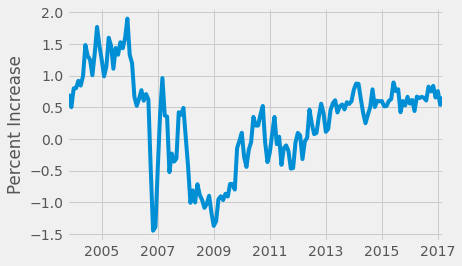

In [516]:
mean = np.mean(trdf, axis = 1)
ax = mean.plot(figsize = (6, 4))
plt.ylabel('Percent Increase')
plt.show()

We can see that the price increase dropped around the 2007 recession and unstable for a few years, then the price increase start to climb up. Recently the increase rate might have been start to stabilize. 

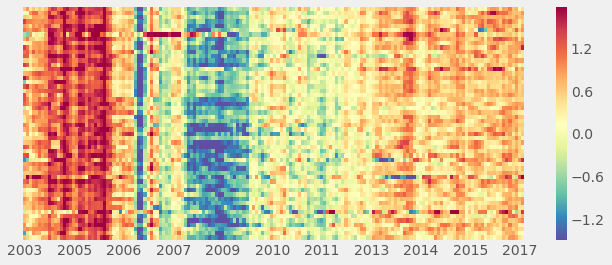

In [518]:
tmp = trdf.copy()
tmp.index = tmp.index.strftime('%Y')

fig = plt.figure(figsize = (10, 4))
ax = sns.heatmap(tmp.T, robust = True, cmap = 'Spectral_r', 
           yticklabels = False, xticklabels = 16)

plt.show()

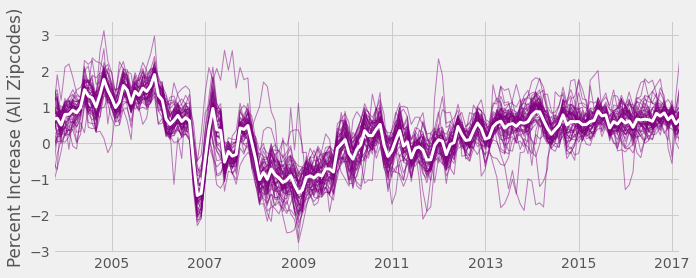

In [519]:
#other_zipcodes = list(trdf.columns.drop(select_zipcodes))
trdf.plot(figsize = (10, 4), lw = 1, color = 'purple', alpha = 0.5)
mean.plot(c = 'white', lw = 3)
plt.legend().set_visible(False)
plt.ylabel('Percent Increase (All Zipcodes)')
plt.show()


We can see that most neighborhoods in the queens tend to have pretty similar shift in percentage changes, but there are definitely handful of outliers (e.g. LIC) that went against the trend. Let's try to plot couple locations that's furthest away from the average line.

## Areas Against the Trend

In [520]:
# calculate absolute difference
diff_df = trdf.apply(lambda x: abs(x-mean))

In [521]:
# add up
diffs = np.sum(diff_df, axis = 0).sort_values(ascending = False)
select_zipcodes = list(diffs.index[0:5])
print(f'top 5 zipcodes with odd trends: {select_zipcodes}')


top 5 zipcodes with odd trends: [11101, 11693, 11692, 11694, 11103]


In [522]:
print(f'closest to the average: {diffs.index[-1]}')

closest to the average: 11432


Mapping the odd locations

In [523]:
diffdf = pd.DataFrame(diffs, columns = ['diff'])
diffdf = diffdf.reset_index()
diffdf = diffdf.rename(columns = {'index': 'zip'})
diffdf['zip'] = diffdf['zip'].astype('str')

Loading GeoJSON

In [524]:
geodata_sel = select_geodata(diffdf['zip'].values)

In [525]:
plot_coropleth(diffdf, ['zip', 'diff'], 
               'Absolute Deviation from Average', geodata_sel)

It seems like the LIC and the Rockaway beach area tend to have different trend compared to overall average.

## Total Percent Increase
Now let's look at the total percent increase in all neighborhoods between 10/2003 to 03/2017

In [526]:
sumdf = pd.DataFrame(trdf.sum(), columns = ['sum'])
sumdf = sumdf.reset_index()
sumdf = sumdf.rename(columns = {'index': 'zip'})
sumdf['zip'] = sumdf['zip'].astype('str')

In [527]:
plot_coropleth(sumdf, ['zip', 'sum'], 
               'Total Percent Increas', geodata_sel)

Overall areas closer to Manhattan did show more total percent increase with a fewer exception (e.g. nearing airport)

## Median Increase
Now let's look at each neighborhood's median percent increase.

In [528]:
mediandf = pd.DataFrame(trdf.median(), columns = ['median'])
mediandf = mediandf.reset_index()
mediandf = mediandf.rename(columns = {'index': 'zip'})
mediandf['zip'] = mediandf['zip'].astype('str')

In [529]:
plot_coropleth(mediandf, ['zip', 'median'], 
               'Median Percent Increas', geodata_sel)

Generally all neighborhoods had an upward trend at all time.

## Select Zipcode
For the initial univariate modeling, I will compare the top 5 zipcodes with the highest deviation from the average and one zipcode closest to the average. 

In [530]:
select_zipcode = [11101, 11693, 11692, 11694, 11103]

In [535]:
def print_all(zipcode):
    df = trdf[zipcode]
    print_summary(df, zipcode)    

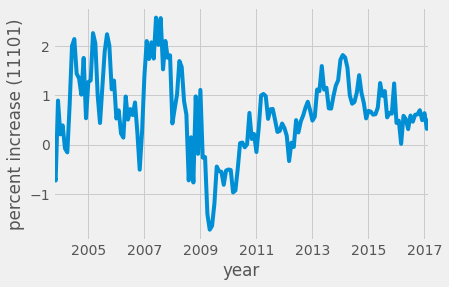

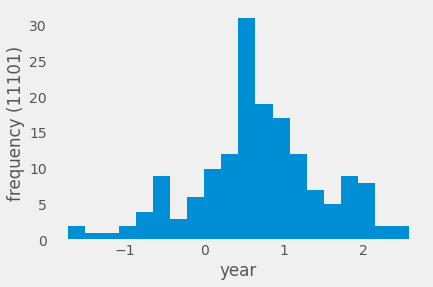

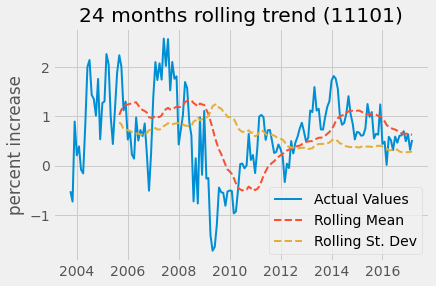

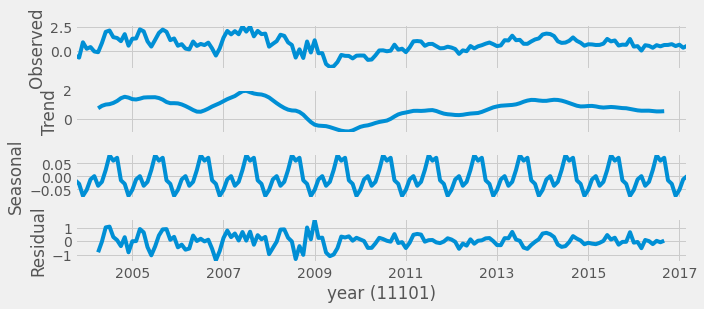

[11101 SUMMARY]
Mean: 0.67
Std: 0.82
Null Rejected (p = 0.0396). 11101 time series is stationary


In [539]:
print_all(select_zipcode[0])

#### 11101 Summary
Dickey Fuller test shows that the data is stationary but the decomposition shows that there's a clear seasonality.

---

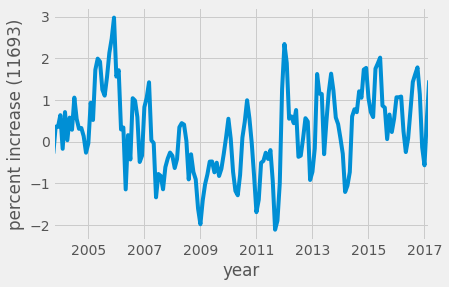

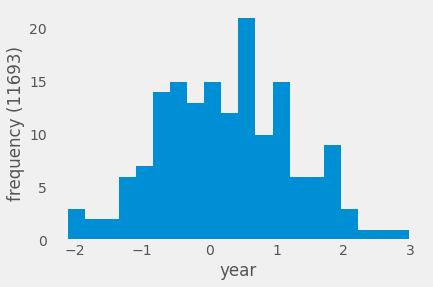

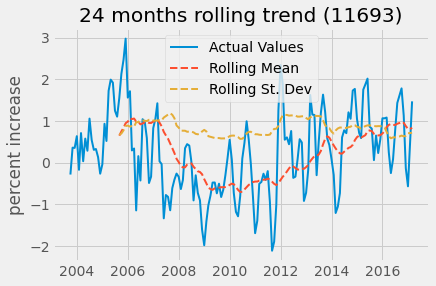

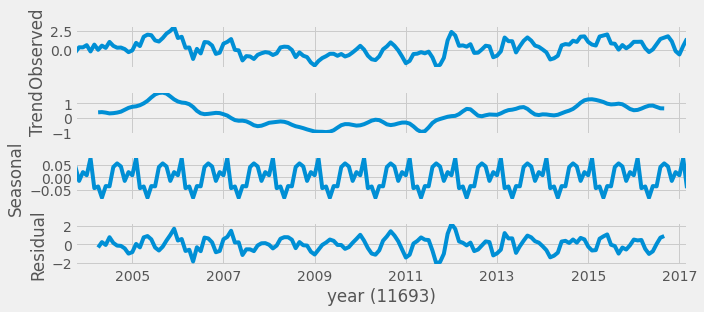

[11693 SUMMARY]
Mean: 0.26
Std: 0.98
Failed to reject the null (p = 0.515). 11693 time series is not stationary


In [540]:
print_all(select_zipcode[1])

#### 11693 Summary
The data is not stationary with stronng seasonality.

---

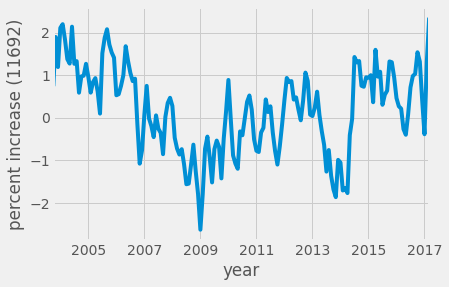

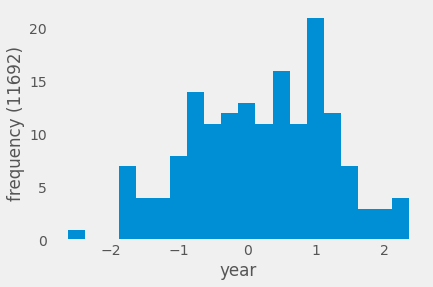

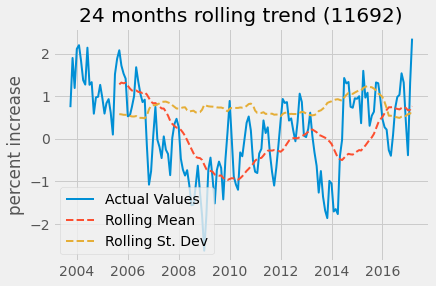

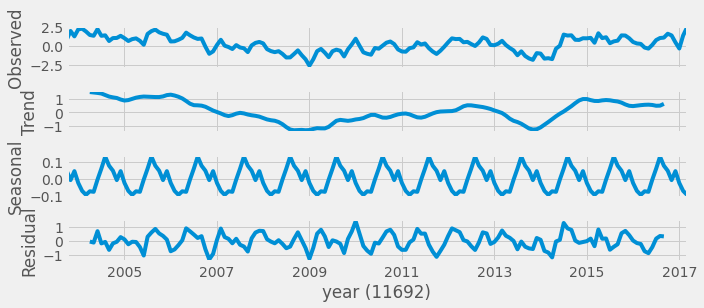

[11692 SUMMARY]
Mean: 0.19
Std: 1.01
Failed to reject the null (p = 0.2646). 11692 time series is not stationary


In [541]:
print_all(select_zipcode[2])

#### 11692 Summary
The data is not stationary with strong seasonality.

---

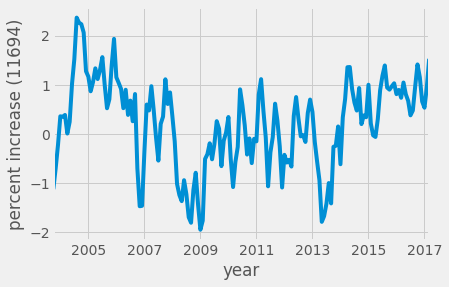

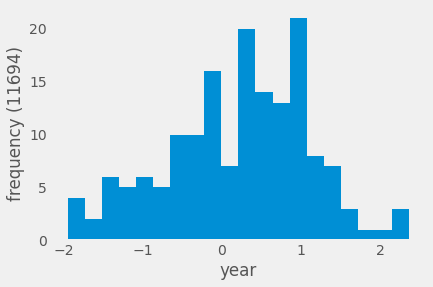

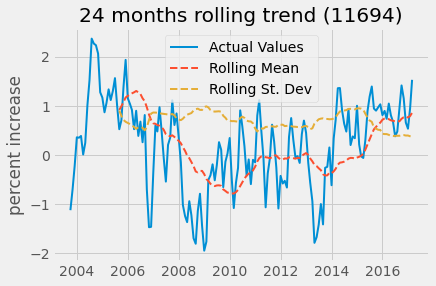

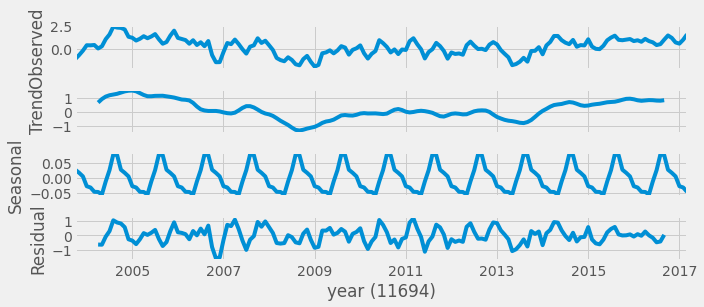

[11694 SUMMARY]
Mean: 0.21
Std: 0.9
Failed to reject the null (p = 0.5557). 11694 time series is not stationary


In [542]:
print_all(select_zipcode[3])

#### 11694 Summary
The data is not stationary with strong seasonality.

---

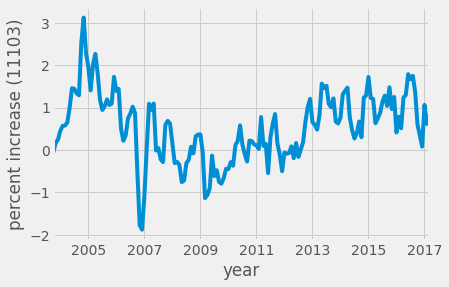

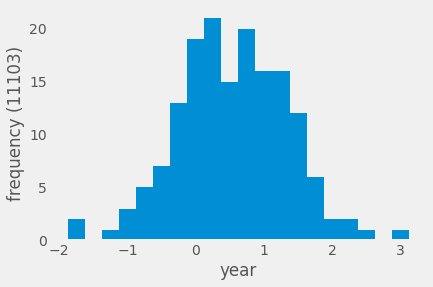

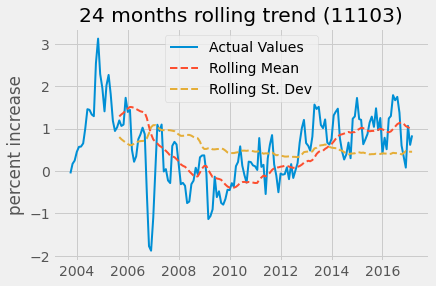

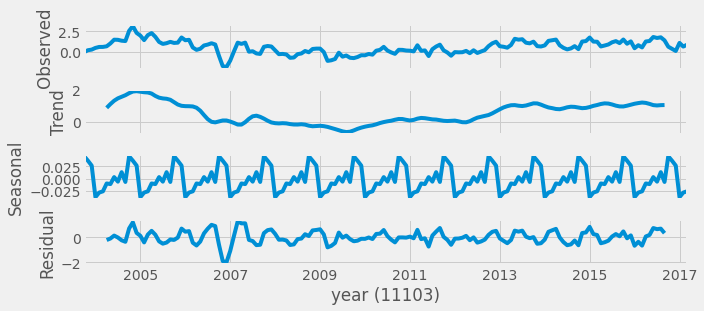

[11103 SUMMARY]
Mean: 0.54
Std: 0.81
Failed to reject the null (p = 0.1339). 11103 time series is not stationary


In [543]:
print_all(select_zipcode[4])

#### 11103 Summary
The data is not stationary with strong seasonality.

---

All of our data shows strong seasonality and some level of trends. Let's see if we can remove the non-stationarity.

# Remoing Trends